In [7]:
import torch
import lovely_tensors as lt
lt.monkey_patch()

from datasets import load_dataset
import warnings
warnings.filterwarnings("ignore")

## Notebook objectives
1. Obtain a standard text dataset from huggingface
2. Code up a loss function.
3. Bring parity with torch's built-in loss functions.

# Download the dataset

In [8]:
data_hf = load_dataset("google-research-datasets/go_emotions")
data_hf

Generating test split: 100%|██████████| 5427/5427 [00:00<00:00, 1765628.90 examples/s]


DatasetDict({
    train: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 43410
    })
    validation: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 5426
    })
    test: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 5427
    })
})

In [21]:
labels = data_hf['train'].features['labels'].feature.names
print(len(labels))
print({i:l for i, l in enumerate(labels)})

28
{0: 'admiration', 1: 'amusement', 2: 'anger', 3: 'annoyance', 4: 'approval', 5: 'caring', 6: 'confusion', 7: 'curiosity', 8: 'desire', 9: 'disappointment', 10: 'disapproval', 11: 'disgust', 12: 'embarrassment', 13: 'excitement', 14: 'fear', 15: 'gratitude', 16: 'grief', 17: 'joy', 18: 'love', 19: 'nervousness', 20: 'optimism', 21: 'pride', 22: 'realization', 23: 'relief', 24: 'remorse', 25: 'sadness', 26: 'surprise', 27: 'neutral'}


There are approx 43k rows in train set and 5k rows in each of validation set and test set. There are 28 labels in our dataset.

In [20]:
data_hf['train'].to_pandas()

,text,labels,id
0,My favourite food is anything I didn't have to...,[27],eebbqej
1,"Now if he does off himself, everyone will thin...",[27],ed00q6i
2,WHY THE FUCK IS BAYLESS ISOING,[2],eezlygj
3,To make her feel threatened,[14],ed7ypvh
4,Dirty Southern Wankers,[3],ed0bdzj
...,...,...,...
43405,Added you mate well I’ve just got the bow and ...,[18],edsb738
43406,Always thought that was funny but is it a refe...,[6],ee7fdou
43407,What are you talking about? Anything bad that ...,[3],efgbhks
43408,"More like a baptism, with sexy results!",[13],ed1naf8


In [28]:
train_y = [x[0] for x in data_hf['train']['labels']]
val_y = [x[0] for x in data_hf['validation']['labels']]
test_y = [x[0] for x in data_hf['test']['labels']]

In [70]:
# Text preprocessing and tokenization
from collections import Counter
import numpy as np

class TextDataProcessor:
    def __init__(self, vocab_size=10000, max_length=128):
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.word_to_idx = {}
        self.idx_to_word = {}
        self.vocab_built = False
        
    def build_vocab(self, texts):
        """Build vocabulary from training texts"""
        word_counts = Counter()
        for text in texts:
            words = text.lower().split()
            word_counts.update(words)
        
        # Keep most frequent words
        most_common = word_counts.most_common(self.vocab_size - 2)  # -2 for PAD and UNK
        
        # Build mappings
        self.word_to_idx = {'<PAD>': 0, '<UNK>': 1}
        self.idx_to_word = {0: '<PAD>', 1: '<UNK>'}
        
        for i, (word, _) in enumerate(most_common, start=2):
            self.word_to_idx[word] = i
            self.idx_to_word[i] = word
            
        self.vocab_built = True
        
    def text_to_indices(self, text):
        """Convert text to sequence of indices"""
        words = text.lower().split()
        indices = []
        for word in words:
            idx = self.word_to_idx.get(word, 1)  # 1 is UNK token
            indices.append(idx)
        
        # Pad or truncate to max_length
        if len(indices) < self.max_length:
            indices.extend([0] * (self.max_length - len(indices)))
        else:
            indices = indices[:self.max_length]
            
        return indices

# Process the go_emotions dataset
processor = TextDataProcessor(vocab_size=5000, max_length=16)

# Extract texts from training set
train_texts = [example['text'] for example in data_hf['train']]
processor.build_vocab(train_texts)

print(f"Vocabulary size: {len(processor.word_to_idx)}")
print(f"Sample vocab: {list(processor.word_to_idx.items())[:10]}")

# Convert texts to indices
train_sequences = [processor.text_to_indices(text) for text in train_texts]
val_sequences = [processor.text_to_indices(text) for text in data_hf['validation']['text']]
test_sequences = [processor.text_to_indices(text) for text in data_hf['test']['text']]

# Convert to tensors
train_X = torch.tensor(train_sequences)
val_X = torch.tensor(val_sequences)
test_X = torch.tensor(test_sequences)

# Get labels (multi-label classification)
train_y = torch.tensor(train_y)
val_y = torch.tensor(val_y)
test_y = torch.tensor(test_y)

print(f"Train shape: {train_X.shape}, {train_y.shape}")
print(f"Val shape: {val_X.shape}, {val_y.shape}")
print(f"Test shape: {test_X.shape}, {test_y.shape}")

Vocabulary size: 5000
Sample vocab: [('<PAD>', 0), ('<UNK>', 1), ('the', 2), ('i', 3), ('to', 4), ('a', 5), ('and', 6), ('you', 7), ('is', 8), ('that', 9)]
Train shape: torch.Size([43410, 16]), torch.Size([43410])
Val shape: torch.Size([5426, 16]), torch.Size([5426])
Test shape: torch.Size([5427, 16]), torch.Size([5427])


In [71]:
train_X.v

tensor[43410, 16] i64 n=694560 (5.3Mb) x∈[0, 4999] μ=286.897 σ=752.645
tensor([[  17, 1225,  708,  ...,    0,    0,    0],
        [  95,   32,   30,  ..., 4177,   27,   49],
        [  84,    2,  203,  ...,    0,    0,    0],
        ...,
        [  31,   26,    7,  ...,   82,   50,  192],
        [  61,   25,    5,  ...,    0,    0,    0],
        [ 333,    2,    1,  ...,    0,    0,    0]])

The training dataset is a large matrix - 43410x16 in size. We will have to take small sets of data (batches) onto the GPU to train the model. Let's code a dataloader now.

In [144]:
from torch.utils.data import DataLoader, TensorDataset

batch_size = 8

train_dataset = TensorDataset(train_X, train_y)
val_dataset = TensorDataset(val_X, val_y)

train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=False, num_workers=0)
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=0)

In [145]:
for batch_x, batch_y in train_dataloader:
    print(f"Batch input shape: {batch_x.shape}")
    print(f"Batch target shape: {batch_y.shape}")
    print(f"Target values:", batch_y)
    break

Batch input shape: torch.Size([8, 16])
Batch target shape: torch.Size([8])
Target values: tensor[8] i64 x∈[2, 27] μ=15.250 σ=10.498 [27, 27, 2, 14, 3, 26, 15, 8]


In [146]:
for b_x, b_y in train_dataloader:
    print(b_x.v, b_y.v)
    break

tensor[8, 16] i64 n=128 (1Kb) x∈[0, 4576] μ=326.953 σ=864.634
tensor([[  17, 1225,  708,    8,  225,    3,  133,   24,    4,    1, 1323,    0,
            0,    0,    0,    0],
        [  95,   32,   30,  164,  166,    1,  197,   64,   55, 1226,  238,    5,
          571, 4177,   27,   49],
        [  84,    2,  203,    8,    1,    1,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0],
        [   4,  102,   68,  107,    1,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0],
        [1877, 3333,    1,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0],
        [ 418,    1,  222,   50,  271,    4,  235,  172,   14,    2,    1, 2035,
         4575,  659,    1, 4576],
        [ 303,    3,  316,    1,    2, 2187,    1,    9,   65,    4,   19, 2525,
           89,   15,   29,    1],
        [  43,  123,   61,    1,    6,    4, 1501,    5,  346,   61, 1129,   15,
          101,  110, 2960,   19]]) tensor[8] i64 x∈[

In [147]:
torch.manual_seed(42)
layer = torch.nn.Embedding(5000, 32)
layer(b_x).mean(dim=1)

print(layer(b_x)[1,:,0].mean())
layer(b_x).mean(dim=1)[1,0]


tensor grad MeanBackward0 -0.522


tensor grad SelectBackward0 -0.522

In [148]:
print(layer(b_x)[0,:,0].mean())
layer(b_x).mean(dim=1)[0,0]

tensor grad MeanBackward0 0.327


tensor grad SelectBackward0 0.327

In [149]:
layer(b_x)[0,:,0].v

tensor[16] x∈[-2.510, 1.931] μ=0.327 σ=1.514 grad SelectBackward0
tensor([-1.7376, -0.8741,  0.7397, -0.6855,  0.5755, -2.5095, -0.5063,  0.3444,
         1.9312, -1.3847, -0.2959,  1.9269,  1.9269,  1.9269,  1.9269,  1.9269],
       grad_fn=<SelectBackward0>)

In [150]:
b_x.v

tensor[8, 16] i64 n=128 (1Kb) x∈[0, 4576] μ=326.953 σ=864.634
tensor([[  17, 1225,  708,    8,  225,    3,  133,   24,    4,    1, 1323,    0,
            0,    0,    0,    0],
        [  95,   32,   30,  164,  166,    1,  197,   64,   55, 1226,  238,    5,
          571, 4177,   27,   49],
        [  84,    2,  203,    8,    1,    1,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0],
        [   4,  102,   68,  107,    1,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0],
        [1877, 3333,    1,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0],
        [ 418,    1,  222,   50,  271,    4,  235,  172,   14,    2,    1, 2035,
         4575,  659,    1, 4576],
        [ 303,    3,  316,    1,    2, 2187,    1,    9,   65,    4,   19, 2525,
           89,   15,   29,    1],
        [  43,  123,   61,    1,    6,    4, 1501,    5,  346,   61, 1129,   15,
          101,  110, 2960,   19]])

In [151]:
layer.weight.v

Parameter[5000, 32] n=160000 (0.6Mb) x∈[-4.590, 4.629] μ=0.001 σ=1.005 grad
tensor([[ 1.9269,  1.4873,  0.9007,  ...,  0.0418, -0.2516,  0.8599],
        [-1.3847, -0.8712, -0.2234,  ...,  1.8446, -1.1845,  1.3835],
        [ 1.4451,  0.8564,  2.2181,  ..., -0.8278,  1.3347,  0.4835],
        ...,
        [-0.2440, -0.0216, -0.9097,  ..., -1.2965, -0.6345, -2.7169],
        [ 1.9982, -1.2546,  2.2254,  ...,  0.2484,  0.4467,  1.4540],
        [ 0.3497,  0.3841,  0.3548,  ..., -0.8024, -0.0384, -1.6425]],
       requires_grad=True)

In [152]:
layer.weight[17,:].v

tensor[32] x∈[-2.072, 2.622] μ=0.182 σ=1.111 grad SliceBackward0
tensor([-1.7376, -0.1254, -1.3658,  1.1117, -0.6228, -0.7892, -0.1678,  1.6433,
         2.0071, -1.2531,  1.1189,  1.7733, -2.0717, -0.4125, -0.9770, -0.0336,
         1.8595,  2.6221,  0.3691,  0.3803,  0.1990, -0.2361,  0.3034, -0.4501,
         0.4739,  0.6503,  1.1662,  0.0169,  0.5326, -0.6035, -0.1743,  0.6092],
       grad_fn=<SliceBackward0>)

In [153]:
t = torch.tensor([1,2,3,4,5,6]).float()
drop = torch.nn.Dropout(0.5)
t.v, drop(t).v

(tensor[6] x∈[1.000, 6.000] μ=3.500 σ=1.871 [1.000, 2.000, 3.000, 4.000, 5.000, 6.000]
 tensor([1., 2., 3., 4., 5., 6.]),
 tensor[6] x∈[0., 6.000] μ=1.000 σ=2.449 [0., 0., 6.000, 0., 0., 0.]
 tensor([0., 0., 6., 0., 0., 0.]))

In [154]:
t = torch.randn((3,4)).float()
drop = torch.nn.Dropout2d(0.5)
t.v, drop(t).v

(tensor[3, 4] n=12 x∈[-2.470, 1.131] μ=0.019 σ=1.026
 tensor([[ 0.0178,  1.0226,  0.3331,  0.5471],
         [ 0.3703, -0.5445, -1.1776,  1.1312],
         [ 0.0808,  0.9616, -2.4696, -0.0486]]),
 tensor[3, 4] n=12 x∈[-4.939, 2.045] μ=-0.116 σ=1.636
 tensor([[ 0.0356,  2.0453,  0.6662,  0.0000],
         [ 0.7406, -0.0000, -0.0000,  0.0000],
         [ 0.1616,  0.0000, -4.9393, -0.0973]]))

Once the embedding layer is defined, we need to reduce along the sequence axis so that we have batch_size x emb_sz number of elements left.

# Define the word embedding + classification model

In [155]:
class EmbeddingClassifier(torch.nn.Module):
    def __init__(self, vocab_size, emb_sz, hidden_dim, num_classes, dropout_rate=0.5):
        super().__init__()
        self.embedding = torch.nn.Embedding(vocab_size, emb_sz, padding_idx=0)
        self.dropout1  = torch.nn.Dropout(p=dropout_rate)
        self.fc1       = torch.nn.Linear(emb_sz, hidden_dim, bias=True)
        self.dropout2  = torch.nn.Dropout(p=dropout_rate)
        self.relu      = torch.nn.ReLU()
        self.fc2       = torch.nn.Linear(hidden_dim, num_classes, bias=True)

    def forward(self, x):
        x = self.embedding(x)      # x shape: (batch_size, seq_len, emb_sz)
        x = self.dropout1(x)       # x shape: (batch_size, seq_len, emb_sz)
        
        # Pooling across the sequence dimension
        x = x.mean(dim=1)          # x shape: (batch_size, emb_sz)

        # FFNs
        x = self.fc1(x)            # x shape: (batch_size, hidden_dim)
        x = self.relu(x)           # x shape: (batch_size, hidden_dim)
        x = self.fc2(x)            # x shape: (batch_size, num_classes)
        return x


In [156]:
model = EmbeddingClassifier(vocab_size=5000, emb_sz=emb_sz, hidden_dim=hidden_dim, num_classes=num_classes)
[p.numel() for p in model.parameters()]

[160000, 160, 5, 140, 28]

In [157]:
emb_sz = 32
hidden_dim = 5
num_classes = 28

# Run the forward pass with cross entropy loss function

In [158]:
# from torchinfo import summary

# model = EmbeddingClassifier(vocab_size=5000, emb_sz=emb_sz, hidden_dim=hidden_dim, output_dim=output_dim)
# summary(model, input_size=(1, 8, 32))

As we have multiple batches in our training dataset, we need to batch the inputs to the model.

In [ ]:
w_means = []
w_norms = []
g_means = []
g_norms = []
losses  = []
val_losses = []

torch.manual_seed(42)
model = EmbeddingClassifier(vocab_size=5000, emb_sz=emb_sz, hidden_dim=hidden_dim, num_classes=num_classes)
criterion = torch.nn.CrossEntropyLoss() # using cross-entropy loss as we're treating this as a multi-class classification problem
# criterion = torch.nn.BCEWithLogitsLoss() # if multi-label :)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

n_epochs = 20
for i in range(n_epochs):
    
    for batch_x, batch_y in train_dataloader:
        y_pred = model(batch_x)

        # print(y_pred.v)
        # print("====")
        # print(batch_y.v)
        # break

        loss = criterion(y_pred, batch_y)

        # reset the gradients
        optimizer.zero_grad()
        
        # backward pass
        loss.backward()

        # update the weights by a small amount
        optimizer.step()

        # print(f" epoch: {i:03d}/{n_epochs:03d} | batch: {b:03d}/train_loss: {loss: 3f} | val_loss: {val_loss: 3f}")

    # eval
    total_val_loss = 0

    with torch.no_grad():
        for batch_x, batch_y in val_dataloader:
            val_preds = model(batch_x)

            val_loss = criterion(val_preds, batch_y)
            total_val_loss += val_loss.item()
    # val_loss = torch.square(torch.abs(val_preds - val_y)).sum()

    print(f" epoch: {i:03d}/{n_epochs:03d} | train_loss: {loss: 3f} | val_loss: {total_val_loss: 3f}")

    all_w_params = torch.cat([p.data.view(-1) for p in model.parameters()])
    w_means.append(torch.mean(all_w_params).item())
    w_norms.append(torch.norm(all_w_params).item())

    all_grad_params = torch.cat([p.grad.data.view(-1) for p in model.parameters()])
    g_means.append(torch.mean(all_grad_params).item())
    g_norms.append(torch.norm(all_grad_params).item())

    losses.append(loss.item())
    val_losses.append(val_loss.item())

 epoch: 000/020 | train_loss:  3.833348 | val_loss:  1844.920487
 epoch: 001/020 | train_loss:  3.807560 | val_loss:  1821.960250
 epoch: 002/020 | train_loss:  3.810906 | val_loss:  1795.788166
 epoch: 003/020 | train_loss:  3.996794 | val_loss:  1763.393883
 epoch: 004/020 | train_loss:  3.907964 | val_loss:  1736.317468
 epoch: 005/020 | train_loss:  3.736235 | val_loss:  1718.434201
 epoch: 006/020 | train_loss:  3.896534 | val_loss:  1695.913247
 epoch: 007/020 | train_loss:  3.875441 | val_loss:  1681.688869
 epoch: 008/020 | train_loss:  3.883334 | val_loss:  1667.356383
 epoch: 009/020 | train_loss:  3.803462 | val_loss:  1643.947300
 epoch: 010/020 | train_loss:  3.732110 | val_loss:  1638.285661
 epoch: 011/020 | train_loss:  3.640146 | val_loss:  1622.126497
 epoch: 012/020 | train_loss:  3.704742 | val_loss:  1610.483477
 epoch: 013/020 | train_loss:  3.597703 | val_loss:  1598.834162
 epoch: 014/020 | train_loss:  3.626173 | val_loss:  1590.968181
 epoch: 015/020 | train_l

The loss values are from the last batch and not a mean value. Let's fix it.

In [161]:
w_means = []
w_norms = []
g_means = []
g_norms = []
losses  = []
val_losses = []

torch.manual_seed(42)
model = EmbeddingClassifier(vocab_size=5000, emb_sz=emb_sz, hidden_dim=hidden_dim, num_classes=num_classes)
criterion = torch.nn.CrossEntropyLoss() # using cross-entropy loss as we're treating this as a multi-class classification problem
# criterion = torch.nn.BCEWithLogitsLoss() # if multi-label :)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

n_epochs = 20
for i in range(n_epochs):
    
    total_train_batches = 0
    total_train_loss = 0
    avg_train_loss = 0.0
    for batch_x, batch_y in train_dataloader:
        y_pred = model(batch_x)

        # print(y_pred.v)
        # print("====")
        # print(batch_y.v)
        # break

        loss = criterion(y_pred, batch_y)

        # reset the gradients
        optimizer.zero_grad()
        
        # backward pass
        loss.backward()

        # update the weights by a small amount
        optimizer.step()

        # print(f" epoch: {i:03d}/{n_epochs:03d} | batch: {b:03d}/train_loss: {loss: 3f} | val_loss: {val_loss: 3f}")
        
        total_train_batches += 1
        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / total_train_batches

    # eval
    total_val_batches = 0
    total_val_loss = 0

    with torch.no_grad():
        for batch_x, batch_y in val_dataloader:
            val_preds = model(batch_x)

            val_loss = criterion(val_preds, batch_y)
            total_val_loss += val_loss.item()
            total_val_batches += 1
    # val_loss = torch.square(torch.abs(val_preds - val_y)).sum()

    avg_val_loss = total_val_loss / total_val_batches
    print(f" epoch: {i:03d}/{n_epochs:03d} | train_loss: {avg_train_loss: 3f} | val_loss: {avg_val_loss: 3f}")

    all_w_params = torch.cat([p.data.view(-1) for p in model.parameters()])
    w_means.append(torch.mean(all_w_params).item())
    w_norms.append(torch.norm(all_w_params).item())

    all_grad_params = torch.cat([p.grad.data.view(-1) for p in model.parameters()])
    g_means.append(torch.mean(all_grad_params).item())
    g_norms.append(torch.norm(all_grad_params).item())

    losses.append(loss.item())
    val_losses.append(val_loss.item())

 epoch: 000/020 | train_loss:  2.834944 | val_loss:  2.717114
 epoch: 001/020 | train_loss:  2.694907 | val_loss:  2.683299
 epoch: 002/020 | train_loss:  2.661216 | val_loss:  2.644754
 epoch: 003/020 | train_loss:  2.618639 | val_loss:  2.597045
 epoch: 004/020 | train_loss:  2.575573 | val_loss:  2.557169
 epoch: 005/020 | train_loss:  2.536135 | val_loss:  2.530831
 epoch: 006/020 | train_loss:  2.504621 | val_loss:  2.497663
 epoch: 007/020 | train_loss:  2.474413 | val_loss:  2.476714
 epoch: 008/020 | train_loss:  2.445559 | val_loss:  2.455606
 epoch: 009/020 | train_loss:  2.424702 | val_loss:  2.421130
 epoch: 010/020 | train_loss:  2.397955 | val_loss:  2.412792
 epoch: 011/020 | train_loss:  2.372851 | val_loss:  2.388993
 epoch: 012/020 | train_loss:  2.349384 | val_loss:  2.371846
 epoch: 013/020 | train_loss:  2.336198 | val_loss:  2.354689
 epoch: 014/020 | train_loss:  2.313081 | val_loss:  2.343105
 epoch: 015/020 | train_loss:  2.297725 | val_loss:  2.332752
 epoch: 

Both the training loss and validation loss are going down. That means the model is learning! Let's amp up the learning rate to see faster converge.

In [164]:
w_means = []
w_norms = []
g_means = []
g_norms = []
losses  = []
val_losses = []

torch.manual_seed(42)
model = EmbeddingClassifier(vocab_size=5000, emb_sz=emb_sz, hidden_dim=hidden_dim, num_classes=num_classes)
criterion = torch.nn.CrossEntropyLoss() # using cross-entropy loss as we're treating this as a multi-class classification problem
# criterion = torch.nn.BCEWithLogitsLoss() # if multi-label :)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

n_epochs = 20
for i in range(n_epochs):
    
    total_train_batches = 0
    total_train_loss = 0
    avg_train_loss = 0.0
    for batch_x, batch_y in train_dataloader:
        y_pred = model(batch_x)

        # print(y_pred.v)
        # print("====")
        # print(batch_y.v)
        # break

        loss = criterion(y_pred, batch_y)

        # reset the gradients
        optimizer.zero_grad()
        
        # backward pass
        loss.backward()

        # update the weights by a small amount
        optimizer.step()

        # print(f" epoch: {i:03d}/{n_epochs:03d} | batch: {b:03d}/train_loss: {loss: 3f} | val_loss: {val_loss: 3f}")
        
        total_train_batches += 1
        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / total_train_batches

    # eval
    total_val_batches = 0
    total_val_loss = 0

    with torch.no_grad():
        for batch_x, batch_y in val_dataloader:
            val_preds = model(batch_x)

            val_loss = criterion(val_preds, batch_y)
            total_val_loss += val_loss.item()
            total_val_batches += 1
    # val_loss = torch.square(torch.abs(val_preds - val_y)).sum()

    avg_val_loss = total_val_loss / total_val_batches
    print(f" epoch: {i:03d}/{n_epochs:03d} | train_loss: {avg_train_loss: 3f} | val_loss: {avg_val_loss: 3f}")

    all_w_params = torch.cat([p.data.view(-1) for p in model.parameters()])
    w_means.append(torch.mean(all_w_params).item())
    w_norms.append(torch.norm(all_w_params).item())

    all_grad_params = torch.cat([p.grad.data.view(-1) for p in model.parameters()])
    g_means.append(torch.mean(all_grad_params).item())
    g_norms.append(torch.norm(all_grad_params).item())

    losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

 epoch: 000/020 | train_loss:  2.467545 | val_loss:  2.315868
 epoch: 001/020 | train_loss:  2.224576 | val_loss:  2.237111
 epoch: 002/020 | train_loss:  2.123658 | val_loss:  2.216756
 epoch: 003/020 | train_loss:  2.064914 | val_loss:  2.170507
 epoch: 004/020 | train_loss:  2.020962 | val_loss:  2.184701
 epoch: 005/020 | train_loss:  1.994138 | val_loss:  2.217112
 epoch: 006/020 | train_loss:  1.969891 | val_loss:  2.200451
 epoch: 007/020 | train_loss:  1.943456 | val_loss:  2.215526
 epoch: 008/020 | train_loss:  1.932503 | val_loss:  2.203277
 epoch: 009/020 | train_loss:  1.921020 | val_loss:  2.237689
 epoch: 010/020 | train_loss:  1.913099 | val_loss:  2.223134
 epoch: 011/020 | train_loss:  1.893092 | val_loss:  2.255760
 epoch: 012/020 | train_loss:  1.885688 | val_loss:  2.279672
 epoch: 013/020 | train_loss:  1.875233 | val_loss:  2.294744
 epoch: 014/020 | train_loss:  1.870966 | val_loss:  2.279229
 epoch: 015/020 | train_loss:  1.855157 | val_loss:  2.288633
 epoch: 

the model is overfitting now. Maybe the lr was way too high!

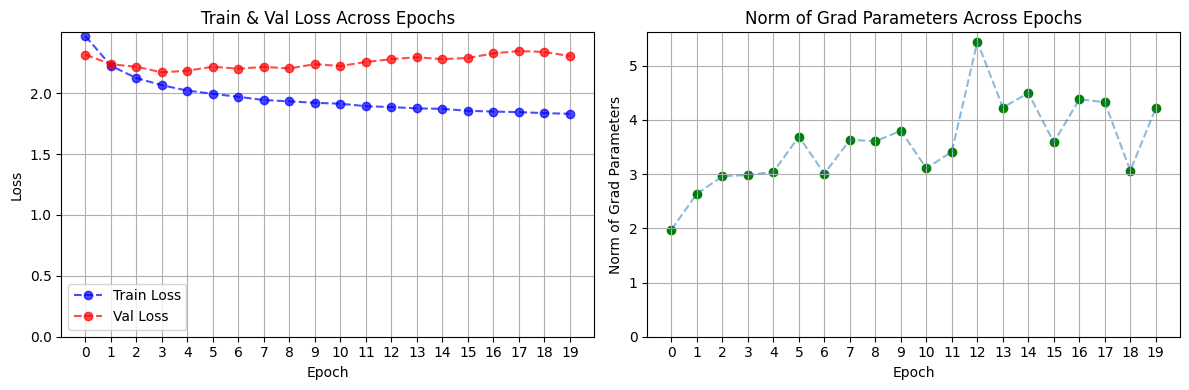

In [165]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

epochs = list(range(n_epochs))

# Plot train and val loss on the same plot
axes[0].plot(epochs, losses, label='Train Loss', color='blue', marker='o', linestyle='dashed', alpha=0.7)
axes[0].plot(epochs, val_losses, label='Val Loss', color='red', marker='o', linestyle='dashed', alpha=0.7)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Train & Val Loss Across Epochs')
axes[0].set_xticks(epochs)
axes[0].set_ylim(bottom=0)  # Start y-axis from zero
axes[0].grid(True)
axes[0].legend()

# Plot gradient norms
axes[1].scatter(epochs, g_norms, color='green')
axes[1].plot(epochs, g_norms, linestyle='dashed', alpha=0.5)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Norm of Grad Parameters')
axes[1].set_title('Norm of Grad Parameters Across Epochs')
axes[1].set_xticks(epochs)
axes[1].set_ylim(bottom=0)  # Start y-axis from zero
axes[1].grid(True)

plt.tight_layout()
plt.show()


2 changes.
1. We must reduce the learning rate to avoid overfitting.
2. Gradient norms are plotted for the last gradient of the batch. However, this is giving us an incomplete picture. We must plot the grad norms for each optimizer step.

Let's make those changes.

# Norms for every optimizer.step() !

In [166]:
w_means = []
w_norms = []
g_means = []
g_norms = []
losses  = []
val_losses = []

torch.manual_seed(42)
model = EmbeddingClassifier(vocab_size=5000, emb_sz=emb_sz, hidden_dim=hidden_dim, num_classes=num_classes)
criterion = torch.nn.CrossEntropyLoss() # using cross-entropy loss as we're treating this as a multi-class classification problem
# criterion = torch.nn.BCEWithLogitsLoss() # if multi-label :)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

n_epochs = 20
for i in range(n_epochs):
    
    total_train_batches = 0
    total_train_loss = 0
    avg_train_loss = 0.0
    for batch_x, batch_y in train_dataloader:
        y_pred = model(batch_x)

        loss = criterion(y_pred, batch_y)

        # reset the gradients
        optimizer.zero_grad()
        
        # backward pass
        loss.backward()

        # update the weights by a small amount
        optimizer.step()

        # print(f" epoch: {i:03d}/{n_epochs:03d} | batch: {b:03d}/train_loss: {loss: 3f} | val_loss: {val_loss: 3f}")
        
        total_train_batches += 1
        total_train_loss += loss.item()

        # logging
        all_w_params = torch.cat([p.data.view(-1) for p in model.parameters()])
        w_means.append(torch.mean(all_w_params).item())
        w_norms.append(torch.norm(all_w_params).item())

        all_grad_params = torch.cat([p.grad.data.view(-1) for p in model.parameters()])
        g_means.append(torch.mean(all_grad_params).item())
        g_norms.append(torch.norm(all_grad_params).item())


    avg_train_loss = total_train_loss / total_train_batches

    # eval
    total_val_batches = 0
    total_val_loss = 0

    with torch.no_grad():
        for batch_x, batch_y in val_dataloader:
            val_preds = model(batch_x)

            val_loss = criterion(val_preds, batch_y)
            total_val_loss += val_loss.item()
            total_val_batches += 1

    avg_val_loss = total_val_loss / total_val_batches
    print(f" epoch: {i:03d}/{n_epochs:03d} | train_loss: {avg_train_loss: 3f} | val_loss: {avg_val_loss: 3f}")

    losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

 epoch: 000/020 | train_loss:  2.834944 | val_loss:  2.717114
 epoch: 001/020 | train_loss:  2.694907 | val_loss:  2.683299
 epoch: 002/020 | train_loss:  2.661216 | val_loss:  2.644754
 epoch: 003/020 | train_loss:  2.618639 | val_loss:  2.597045
 epoch: 004/020 | train_loss:  2.575573 | val_loss:  2.557169
 epoch: 005/020 | train_loss:  2.536135 | val_loss:  2.530831
 epoch: 006/020 | train_loss:  2.504621 | val_loss:  2.497663
 epoch: 007/020 | train_loss:  2.474413 | val_loss:  2.476714
 epoch: 008/020 | train_loss:  2.445559 | val_loss:  2.455606
 epoch: 009/020 | train_loss:  2.424702 | val_loss:  2.421130
 epoch: 010/020 | train_loss:  2.397955 | val_loss:  2.412792
 epoch: 011/020 | train_loss:  2.372851 | val_loss:  2.388993
 epoch: 012/020 | train_loss:  2.349384 | val_loss:  2.371846
 epoch: 013/020 | train_loss:  2.336198 | val_loss:  2.354689
 epoch: 014/020 | train_loss:  2.313081 | val_loss:  2.343105
 epoch: 015/020 | train_loss:  2.297725 | val_loss:  2.332752
 epoch: 

In [ ]:
# import matplotlib.pyplot as plt
# %matplotlib inline

# fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# epochs = list(range(n_epochs))
# steps = list(range(total_train_batches * n_epochs))

# # Plot train and val loss on the same plot
# axes[0].plot(epochs, losses, label='Train Loss', color='blue', marker='o', linestyle='dashed', alpha=0.7)
# axes[0].plot(epochs, val_losses, label='Val Loss', color='red', marker='o', linestyle='dashed', alpha=0.7)
# axes[0].set_xlabel('Epoch')
# axes[0].set_ylabel('Loss')
# axes[0].set_title('Train & Val Loss Across Epochs')
# axes[0].set_xticks(epochs)
# axes[0].set_ylim(bottom=0)  # Start y-axis from zero
# axes[0].grid(True)
# axes[0].legend()

# # Plot gradient norms
# axes[1].scatter(steps, g_norms, color='green')
# axes[1].plot(steps, g_norms, linestyle='dashed', alpha=0.5)
# axes[1].set_xlabel('Steps')
# axes[1].set_ylabel('Norm of Grad Parameters')
# axes[1].set_title('Norm of Grad Parameters Across steps')
# axes[1].set_xticks(steps)
# axes[1].set_ylim(bottom=0)  # Start y-axis from zero
# axes[1].grid(True)

# plt.tight_layout()
# plt.show()
